### This notebook will demonstrate how how our code function is able to checkpoint save while training the model. 

Model will be stopped prematurely while training. This model can be reloaded at the last saved checkpoint and continue retraining. Demonstration will be applied to the first model (normal vs infected classifier) however checkpoint saving, loading, retraining functions can be applied to both models 

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import sys
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import pandas as pd
import sklearn as sk
import os
import time 
from datetime import datetime
import pytz

# importing custom datasets for model 1
from customDataset_1 import Lung_Train_Dataset_1, Lung_Test_Dataset_1, Lung_Valid_Dataset_1, Lung_Train_Dataset_1_Aug
from customDataset_2 import Lung_Train_Dataset_2, Lung_Valid_Dataset_2, Lung_Test_Dataset_2, Lung_Train_Dataset_2_Aug
from customCnn_1 import NN_Classifier_1,train_model_1
from customCnn_2 import NN_Classifier_2, train_model_2
from utils import load_model, plot_curves, test_model, predict_images, validation, save_checkpoint


print(f"Pytorch Version: {torch.__version__}")
print(f"Python Version: {sys.version}")
print(f"Pandas Version: {pd.__version__}")
print(f"Sklearn Version: {sk.__version__}")
print(f"GPU is", "avaialable" if torch.cuda.is_available() else "not available")
print(torch.cuda.get_device_name(0))

Pytorch Version: 1.4.0
Python Version: 3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]
Pandas Version: 0.25.3
Sklearn Version: 0.23.1
GPU is avaialable
GRID V100DX-8Q


In [2]:
# image paths
train_normal_pics = 'small_proj_dataset/train/normal'
train_non_covid_pics = 'small_proj_dataset/train/infected/non-covid'
train_covid_pics = 'small_proj_dataset/train/infected/covid'
test_normal_pics = 'small_proj_dataset/test/normal'
test_non_covid_pics = 'small_proj_dataset/test/infected/non-covid'
test_covid_pics = 'small_proj_dataset/test/infected/covid'
val_normal_pics = 'small_proj_dataset/val/normal'
val_non_covid_pics = 'small_proj_dataset/val/infected/non-covid'
val_covid_pics = 'small_proj_dataset/val/infected/covid'

# checking the number of datasets present 
train_normal = len([name for name in os.listdir(train_normal_pics) if os.path.isfile(os.path.join(train_normal_pics, name))])
train_infected_non_covid = len([name for name in os.listdir(train_non_covid_pics) if os.path.isfile(os.path.join(train_non_covid_pics, name))])
train_infected_covid = len([name for name in os.listdir(train_covid_pics) if os.path.isfile(os.path.join(train_covid_pics, name))])
test_normal = len([name for name in os.listdir(test_normal_pics) if os.path.isfile(os.path.join(test_normal_pics, name))])
test_infected_non_covid = len([name for name in os.listdir(test_non_covid_pics) if os.path.isfile(os.path.join(test_non_covid_pics, name))])
test_infected_covid = len([name for name in os.listdir(test_covid_pics) if os.path.isfile(os.path.join(test_covid_pics, name))])
valid_normal = len([name for name in os.listdir(val_normal_pics) if os.path.isfile(os.path.join(val_normal_pics, name))])
valid_infected_non_covid = len([name for name in os.listdir(val_non_covid_pics) if os.path.isfile(os.path.join(val_non_covid_pics, name))])
valid_infected_covid = len([name for name in os.listdir(val_covid_pics) if os.path.isfile(os.path.join(val_covid_pics, name))])

In [3]:
# initialising custom Dataset 
ld_train = Lung_Train_Dataset_1(train_normal,train_infected_covid, train_infected_non_covid)
ld_test = Lung_Test_Dataset_1(test_normal,test_infected_covid,test_infected_non_covid)
ld_val = Lung_Valid_Dataset_1(valid_normal, valid_infected_covid, valid_infected_non_covid)

In [4]:
# creating Dataloader for train, validation, test data set
batch_size_value = 32

train_loader = DataLoader(ld_train, batch_size = batch_size_value, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = batch_size_value, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = batch_size_value, shuffle = True)

# check information on a single batch on the training dataset
print(f'Number of training data: {len(ld_train)}')
print(f'Number of batches per training data: {len(train_loader)}')
dataiter = iter(train_loader)
images, labels, path = dataiter.next()  # taking the first batch
print(f'Shape of images in a single batch: {images.shape}') # output in the sequence of number of images, channels, height, width
print(f'Shape of labels in a single batch: {labels.shape}') # output is of size of number of images, each value representing label class 0,1,2

Number of training data: 5216
Number of batches per training data: 163
Shape of images in a single batch: torch.Size([32, 1, 150, 150])
Shape of labels in a single batch: torch.Size([32])


In [5]:
# initialising model
labelsdict = {0: 'normal', 1: 'infected'}
learning_rate = 0.001
model_1 = NN_Classifier_1(output_size = len(labelsdict))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr = learning_rate )
epochs = 10

# saving paths
model_name_1 = 'model_1(normal_vs_infected)'
model_path_1 = f'models/checkpointing/{model_name_1}.pth'
model_path_1_best = f'models/checkpointing/{model_name_1}_best.pth'
loss_graph_1 = f'graphs/checkpointing/{model_name_1}_loss'
accuracy_graph_1 = f'graphs/checkpointing/{model_name_1}_accuracy'

In [6]:
# model training stopped prematurely at 5th epoch
model_one = train_model_1(model = model_1, n_epoch = epochs, labelsdict = labelsdict, criterion = criterion, optimizer = optimizer ,device = 'cuda', trainloader= train_loader, validloader= test_loader, train_data = ld_train, model_name = model_name_1, model_path = model_path_1, model_path_best = model_path_1_best, loss_graph = loss_graph_1, accuracy_graph = accuracy_graph_1) 

Training custom CNN Model to distinguish normal and infected lungs
total epochs: 10
Epoch: 1/10 -  Time: 2021-03-21 11:54:24.970447+08:00  Training Loss: 1.293 -  Validation Loss: 0.388 -  Training Accuracy: 0.763 -  Validation Accuracy: 0.824
Validation loss decreased (1000.000000 --> 0.387653).  Saving model ...
Epoch: 2/10 -  Time: 2021-03-21 11:54:33.691549+08:00  Training Loss: 0.189 -  Validation Loss: 0.379 -  Training Accuracy: 0.932 -  Validation Accuracy: 0.859
Validation loss decreased (0.387653 --> 0.378811).  Saving model ...
Epoch: 3/10 -  Time: 2021-03-21 11:54:42.454983+08:00  Training Loss: 0.152 -  Validation Loss: 0.401 -  Training Accuracy: 0.945 -  Validation Accuracy: 0.846
Epoch: 4/10 -  Time: 2021-03-21 11:54:49.902181+08:00  Training Loss: 0.137 -  Validation Loss: 0.376 -  Training Accuracy: 0.951 -  Validation Accuracy: 0.875
Validation loss decreased (0.378811 --> 0.376457).  Saving model ...
Epoch: 5/10 -  Time: 2021-03-21 11:54:58.612365+08:00  Training Lo

KeyboardInterrupt: 

model stopped training at epoch:5


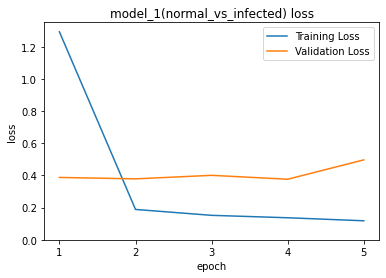

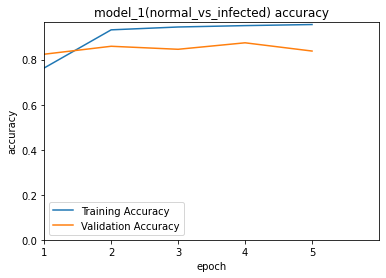

In [8]:
# loading checkpoint model which was previously stopped prematurely during training
ckpt_model = load_model(NN_Classifier_1(output_size = len(labelsdict)), model_path_1)
print(f'model stopped training at epoch:{ckpt_model.epoch}')
# loss and accuracy graph displays training of checkpoint model until 5th epoch
plot_curves(ckpt_model.start_epoch, ckpt_model.epoch, ckpt_model.loss_acc, ckpt_model.model_name, loss_graph_1, accuracy_graph_1)


Training custom CNN Model to distinguish normal and infected lungs
total epochs: 10
Retraining model continuing from epoch 6
Epoch: 6/10 -  Time: 2021-03-21 11:57:23.308433+08:00  Training Loss: 0.100 -  Validation Loss: 0.504 -  Training Accuracy: 0.964 -  Validation Accuracy: 0.833
Epoch: 7/10 -  Time: 2021-03-21 11:57:30.418242+08:00  Training Loss: 0.099 -  Validation Loss: 0.526 -  Training Accuracy: 0.965 -  Validation Accuracy: 0.833
Epoch: 8/10 -  Time: 2021-03-21 11:57:37.538093+08:00  Training Loss: 0.101 -  Validation Loss: 0.486 -  Training Accuracy: 0.962 -  Validation Accuracy: 0.838
Validation loss decreased (0.496873 --> 0.486319).  Saving model ...
Epoch: 9/10 -  Time: 2021-03-21 11:57:46.447745+08:00  Training Loss: 0.095 -  Validation Loss: 0.495 -  Training Accuracy: 0.967 -  Validation Accuracy: 0.838
Epoch: 10/10 -  Time: 2021-03-21 11:57:53.618255+08:00  Training Loss: 0.103 -  Validation Loss: 0.501 -  Training Accuracy: 0.964 -  Validation Accuracy: 0.838
model

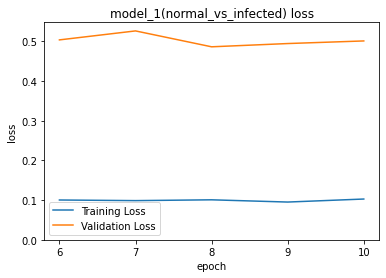

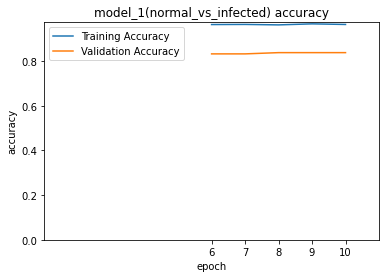

In [11]:
# Resume and complete training of loaded ckpt model
model_complete = train_model_1(model = ckpt_model, n_epoch = epochs, labelsdict = ckpt_model.labelsdict, criterion = ckpt_model.loss, optimizer = ckpt_model.optimizer ,device = 'cuda', trainloader= train_loader, validloader= test_loader, train_data = ld_train, model_name = ckpt_model.model_name, model_path = model_path_1, model_path_best = model_path_1_best, loss_graph = loss_graph_1, accuracy_graph = accuracy_graph_1, start_epoch=ckpt_model.epoch, valid_loss = ckpt_model.val_loss)